In [27]:
import tensorflow as tf
import time, os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import pandas as pd

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
model = tf.keras.models.load_model('../models/CNNvFinal.h5', custom_objects={"precision_m": precision_m, "f1_m":f1_m,"recall_m":recall_m})
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

In [6]:
for layer in model.layers:
    print(layer.output_shape)

(None, 126, 126, 128)
(None, 63, 63, 128)
(None, 61, 61, 256)
(None, 30, 30, 256)
(None, 28, 28, 256)
(None, 200704)
(None, 256)
(None, 10)


In [14]:
isStego=lambda x:1 if x[:6]=="stego_" else 0
getYFromImageList=lambda x: [isStego(element) for element in x]
dirs= [x[0] for x in os.walk("../../../ColorSamples/S-Uniward_50-50_05/")]
images=os.listdir(dirs[0])
random.shuffle(images)
images=images[:20000]
y=np.array(getYFromImageList(images))

In [19]:
pd.DataFrame(y).describe()

,0
count,20000.000000
mean,0.500500
std,0.500012
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [21]:
x=np.array([cv2.imread("../../../ColorSamples/S-Uniward_50-50_05/"+images[i])/255 for i in range(len(images))],dtype="float32")

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m ,precision_m,recall_m])

In [29]:
results = model.evaluate(x, y, batch_size=64)

113/313 [=========>....................] - ETA: 4:28 - loss: 6.3961 - accuracy: 0.5030 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

KeyboardInterrupt: 

In [30]:
y_pred=model.predict(x)

In [32]:
y_pred

array([[  0.16341163,   0.21948937, -13.902733  , ..., -13.86911   ,
        -13.896526  , -13.887461  ],
       [  0.16341163,   0.21948937, -13.902733  , ..., -13.86911   ,
        -13.896526  , -13.887461  ],
       [  0.16341163,   0.21948937, -13.902733  , ..., -13.86911   ,
        -13.896526  , -13.887461  ],
       ...,
       [  0.16341163,   0.21948937, -13.902733  , ..., -13.86911   ,
        -13.896526  , -13.887461  ],
       [  0.16341163,   0.21948938, -13.902733  , ..., -13.86911   ,
        -13.896526  , -13.887461  ],
       [  0.16341163,   0.21948938, -13.902733  , ..., -13.86911   ,
        -13.896526  , -13.887461  ]], dtype=float32)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

In [36]:
model.layers[-1].get_config()

{'name': 'dense_1',
 'trainable': True,
 'dtype': 'float32',
 'units': 10,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [41]:
len(model.layers[-1].get_weights()[0])

256

In [35]:
for layer in model.layers:
    print(layer.get_config(), layer.get_weights())

{'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 128, 128, 3), 'dtype': 'float32', 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[[ 1.91313345e-02, -1.83838401e-02, -2.82930210e-02, ...,
          -1.10657312e-01, -1.11488603e-01,  1.77777670e-02],
         [ 5.43290675e-02, -8.94830003e-02, -6.27091601e-02, ...,
          -5.48125207e-02, -8.79582390e-02,  2.24033836e-02],
         [ 3.86968926e-02, -2.02749670e-02, -1.68340355e-02, ...,
          -1.16805233e-01, -7.36361146e-02,  4.31788303e-02]],

        [[ 5.11650741e-02, -8.01550448e-02, -1.31

In [25]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy', f1_m ,precision_m,recall_m])

In [26]:
results = model.evaluate(x, y, batch_size=64)

 54/313 [====>.........................] - ETA: 5:42 - loss: 6.3321 - accuracy: 0.4980 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
x.shape

In [24]:
x=x.reshape(1000, 128, 128, 3)

In [30]:
x[0].shape

(128, 128, 3)

In [34]:
t=time.time()
model(x[0:1000])
elapsed=time.time()-t
print(elapsed)

55.95316529273987


In [35]:
elapsed/1000

0.055953165292739866

In [77]:
times=[]

In [80]:
for i in range(5,1000,5):
    t=time.time()
    model(x[0:i])
    elapsed=time.time()-t
    times.append(elapsed)


In [87]:
dir(plt)

['Annotation',
 'Arrow',
 'Artist',
 'AutoLocator',
 'Axes',
 'Button',
 'Circle',
 'Figure',
 'FigureCanvasBase',
 'FixedFormatter',
 'FixedLocator',
 'FormatStrFormatter',
 'Formatter',
 'FuncFormatter',
 'GridSpec',
 'IndexLocator',
 'Line2D',
 'LinearLocator',
 'Locator',
 'LogFormatter',
 'LogFormatterExponent',
 'LogFormatterMathtext',
 'LogLocator',
 'MaxNLocator',
 'MouseButton',
 'MultipleLocator',
 'Normalize',
 'NullFormatter',
 'NullLocator',
 'Number',
 'PolarAxes',
 'Polygon',
 'Rectangle',
 'ScalarFormatter',
 'Slider',
 'Subplot',
 'SubplotSpec',
 'SubplotTool',
 'Text',
 'TickHelper',
 'Widget',
 '_INSTALL_FIG_OBSERVER',
 '_IP_REGISTERED',
 '_IoffContext',
 '_IonContext',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_api',
 '_auto_draw_if_interactive',
 '_backend_mod',
 '_code_objs',
 '_copy_docstring_and_deprecators',
 '_get_required_interactive_framework',
 '_interactive_bk',
 '_log',
 '_pylab_hel

In [123]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [132]:
y_test.shape

(200,)

In [126]:
from sklearn.model_selection import train_test_split

In [146]:
results=model.predict(X_test)

In [152]:
y_test[10]

0

In [150]:
results[0]

array([  0.16341163,   0.21948937, -13.902733  , -14.00407   ,
       -14.048599  , -13.969959  , -13.935632  , -13.86911   ,
       -13.896526  , -13.887461  ], dtype=float32)

In [89]:
times[0]

0.2469933032989502

In [105]:
[i for i in range(5,1000,125)]

[0, 125, 250, 375, 500, 625, 750, 875]

In [133]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

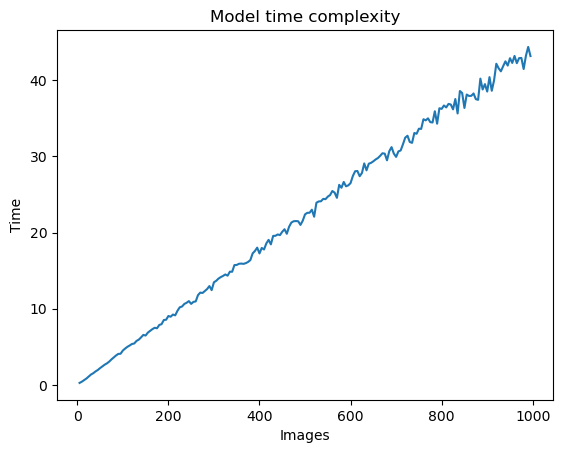

In [116]:
fig, ax = plt.subplots()
plt.title("Model time complexity")
plt.xlabel("Images")
plt.ylabel("Time")
plt.plot([i for i in range(5,1000,5)], times)
plt.show()

In [59]:
model.metrics

In [72]:
model.metrics[2].metrics

[]

In [37]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'filters': 128,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d',
    'trainable': True,
  

In [38]:
model.loss

In [40]:
dir(model.optimizer)

['_HAS_AGGREGATE_GRAD',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_aggregate_gradients',
 '_assert_valid_dtypes',
 '_call_if_callable',
 '_checkpoint_dependencies',
 '_clip_gradients',
 '_compute_gradients',
 '_create_all_weights',
 '_create_hypers',
 '_create_or_restore_slot_variable',
 '_create_slots',
 '_decayed_lr',
 '_deferred_dependencies',
 '_deferred_slot_restorations',
 '_dense_apply_args',
 '_distributed_apply',
 '_distribution_strategy',
 '_distribution_strategy_scope',
 '_fallback_apply_state',
 '_gather_saveables_for_checkpoint',
 '_get_hyper',
 '_handle_deferred_dependencies

In [36]:
dir(model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_los

In [27]:
times=[]
for i in range(len(x)):
    t=time.time()
    model(x[0:1000])
    elapsed=time.time()-t
    times.append(elapsed)

KeyboardInterrupt: 

In [ ]:
times.mean()

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               5